# Make and write templates, make and write synthetic data (pulse + white noise), 

In [1]:
import cdms
import ROOT
import numpy as np
import matplotlib.pyplot as plt
import pandas
#from scipy.optimize import curve_fit
%matplotlib inline

# raw pulse, this is for CDMS-V04-07 
from rawio.IO import *

# general parameters
tracelength = 32768
samplerate = 625000.


Welcome to JupyROOT 6.24/06


In [2]:
def low_pass_filter(data, alpha):
    """
    Applies a simple low-pass filter to a data series.

    :param data: a list or array of numeric data
    :param alpha: a smoothing factor between 0 and 1
    :return: a list containing the filtered data
    """
    filtered = [data[0]]  # initialize the filtered data with the first value of the input
    for i in range(1, len(data)):
        filtered.append(alpha * data[i] + (1 - alpha) * filtered[-1])
    return filtered

# double exponential function to mimic the pulse
def two_exp_fit(x, amp, t1, t2, baseline, pretrigger):
    y = np.where(x <= pretrigger, baseline, -(amp * np.exp(-(x-pretrigger) / t1 /samplerate) - amp * np.exp(-(x-pretrigger) / t2/samplerate)) + baseline)
    return y

## Make templates

In [3]:
# parameters for functional form template
baseline = 0 # template has a baseline of 0
pretrigger = 16884 # 1024 * 16 + 500
t1 = 40e-6 #rise time
t2 = 500e-6 #fall time
amp = 200 # will be normalized so doesn't matter here

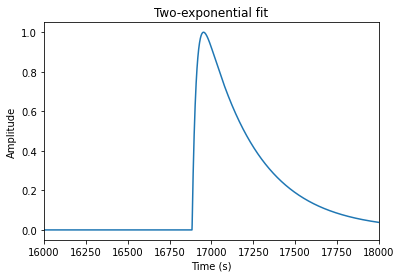

In [4]:
# Generate some x values to plot the function
x = np.linspace(0, tracelength, tracelength)

# Compute the function values for the given parameters and x values
y = two_exp_fit(x, amp, t1, t2, baseline, pretrigger)

# Scale y so that the maximum of y is 1
max_y = np.max(y)
y_scaled = y / max_y

# Plot the function
plt.plot(x, y_scaled)
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')
plt.xlim(16000,18000)
plt.title('Two-exponential fit')
plt.show()



# Write all templates 

In [5]:
# Define the channel names and their corresponding t1 and t2 values
phonon_chans = ['PAS1', 'PBS1', 'PCS1', 'PDS1', 'PES1', 'PFS1', 'PAS2', 'PBS2', 'PCS2', 'PDS2', 'PES2', 'PFS2', 'PS1', 'PS2', 'PT']
#t1_values = [7e-5, 1e-3, 2e-3, 3e-4, 1e-3, 5e-4, 1e-4, 7e-5, 1.5e-4, 1.5e-4, 2e-4, 2e-4, 2e-4, 1e-4, 1e-4]
#t2_values = [2e-3, 1e-2, 8e-3, 2e-2, 1e-2, 3e-3, 4e-4, 8e-4, 3e-3, 8e-3, 4e-3, 3e-3, 1.5e-2, 3.5e-3, 6e-3]

# Create a new root file with the given name
#file_name = "Templates_Synthetic_nonHybrid_20230610_YL.root"
file_name = "Templates_Synthetic_Hybrid_20230610_YL.root"
root_file = ROOT.TFile(file_name, "RECREATE")

# Create a TDirectory in the root file
#directory_name = "zip14"
directory_name = "zip5"
directory = root_file.mkdir(directory_name)
directory.cd()

# Loop over all channels and create a TH1D for each channel
#for chan_name, t1, t2 in zip(all_chan, t1_values, t2_values):
for chan_name in phonon_chans:
    # Generate some x values to plot the function
    #x = np.linspace(0, 15632, 15632)
    # Compute the function values for the given parameters and x values
    #y = two_exp_fit(x, a1, t1, a2, t2, t3, t4)
    # Scale y so that the maximum of y is 1
    #max_y = np.max(y)
    #y_scaled = y / max_y

    # Create a TH1D with 32768 bins
    hist_name = chan_name
    hist_title = "Histogram of Function Form for Channel " + chan_name
    num_bins = tracelength
    x_min = 0
    x_max = tracelength
    histogram = ROOT.TH1D(hist_name, hist_title, num_bins, x_min, x_max)

    # Fill the histogram with the scaled function values
    for i, value in enumerate(y_scaled):
        histogram.SetBinContent(i+1, value)

    # Write the histogram to the root file
    histogram.Write()

# Close the root file
root_file.Close()


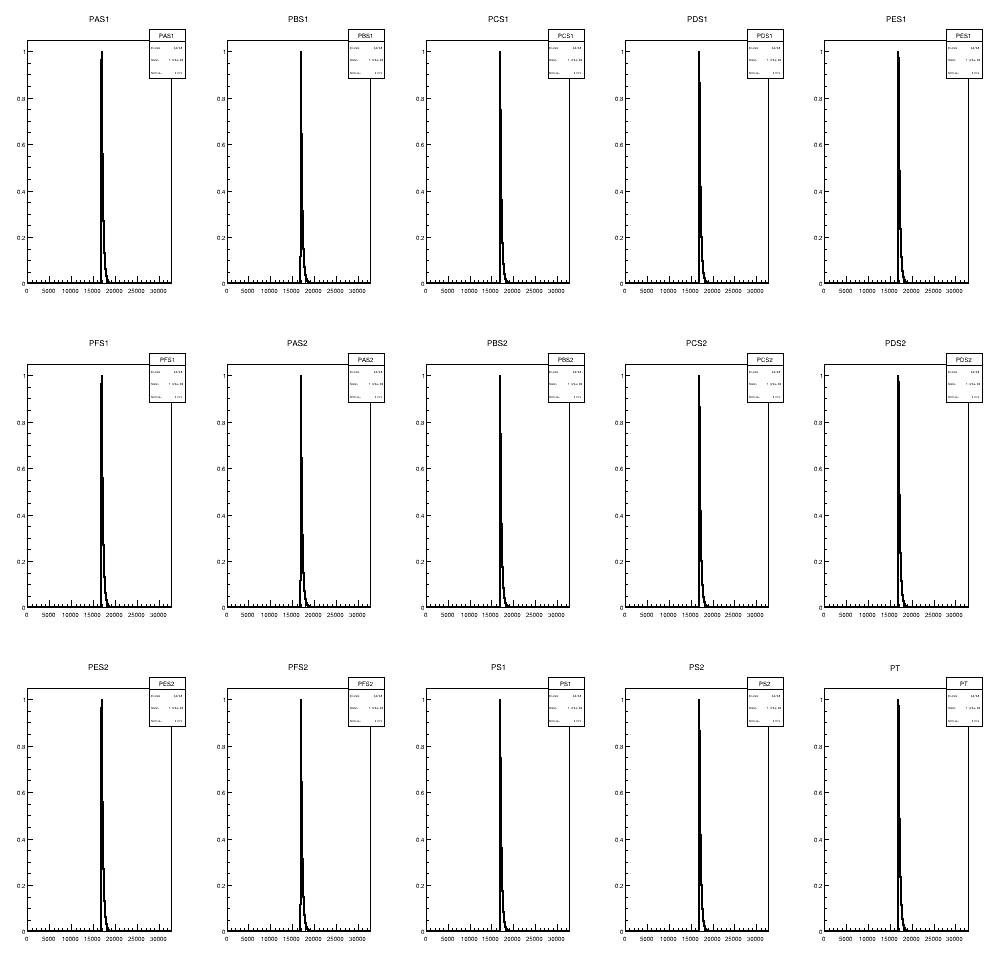

In [6]:
# read back the templates to check things look good

# Open the root file in read mode
#file_name = "Templates_Synthetic_nonHybrid_20230610_YL.root"
file_name = "Templates_Synthetic_Hybrid_20230610_YL.root"
root_file = ROOT.TFile(file_name, "READ")

# Create a canvas to plot all TH1Ds
canvas = ROOT.TCanvas("canvas", "Histograms", 1000, 1000)
canvas.Divide(5, 3)

# Loop over all channels and plot their respective TH1D
all_chan = ['PAS1', 'PBS1', 'PCS1', 'PDS1', 'PES1', 'PFS1', 'PAS2', 'PBS2', 'PCS2', 'PDS2', 'PES2', 'PFS2', 'PS1', 'PS2', 'PT']

for i, channel_name in enumerate(all_chan):
    # Retrieve the TH1D from the root file
    hist_name = channel_name
    histogram = root_file.Get(directory_name + "/" + hist_name)

    # Normalize the histogram so that the integral is 1
    #histogram.Scale(1.0 / histogram.Integral())

    # Set the properties of the histogram and draw it on the canvas
    histogram.SetLineColor(ROOT.kBlack)
    histogram.SetLineWidth(2)
    histogram.SetTitle(channel_name)
    canvas.cd(i+1)
    histogram.Draw()

# Update and display the canvas
canvas.Update()
canvas.Draw()


## Generate synthetic data

In [8]:
# parameters for functional form template
baseline = 32000 # pulse has a baseline of 32000
pretrigger = 16800 # 1024 * 16 + 500
t1 = 40e-6 #rise time
t2 = 500e-6 #fall time
amp = 200 # can be expanded to a distribution if needed

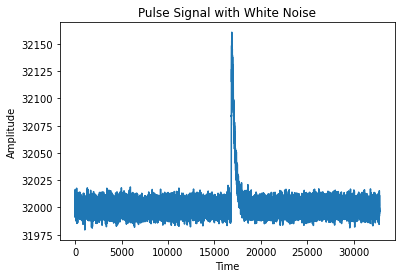

In [9]:
# generate an example pulse with noise

def add_white_noise(y, white_noise):
    y_with_noise = y + white_noise
    return y_with_noise

# generate white noise
white_noise = np.random.normal(0, 5, tracelength)

# Generate some x values to plot the function
x = np.linspace(0, tracelength, tracelength)

# Compute the function values for the given parameters and x values
y = two_exp_fit(x, amp, t1, t2, baseline, pretrigger)

# Add the white noise to the pulse signal
y_with_noise = add_white_noise(y, white_noise)

# Plot the pulse signal with noise
plt.plot(x, y_with_noise)
plt.xlabel('Time')
plt.ylabel('Amplitude')
plt.title('Pulse Signal with White Noise')
plt.show()

## write synthetic data to ROOT file

In [42]:
# write to ROOT file
num_events = 600
outfile = ROOT.TFile("synthetic_pulses_20230610_YL.root", "RECREATE")

for i in range(num_events):
    white_noise = np.random.normal(0, 5, tracelength)
    
    # Add the white noise to the pulse signal
    y_with_noise = add_white_noise(y, white_noise)
    
    # round to int
    y_with_noise_int = np.round(y_with_noise)
    
    # Plot the pulse signal with noise
    #plt.plot(x, y_with_noise)
    #plt.xlabel('Time')
    #plt.ylabel('Amplitude')
    #plt.title(f'Pulse Signal with White Noise {i+1}')
    #plt.show()

    # Create a new TH1D for the pulse signal with noise
    hist = ROOT.TH1I(f"pulse_{i+1}", f"Pulse Signal with Noise {i+1}", tracelength, 0, tracelength)
    
    # Fill the histogram with the pulse signal with noise
    for j in range(tracelength):
        #hist.SetBinContent(j+1, y_with_noise[j])
        hist.SetBinContent(j+1, y_with_noise_int[j])
        
    # Print progress after every 100 pulses
    if (i+1) % 100 == 0:
        print(f"Processed {i+1} pulses out of {num_events}")
    
    # Write the histogram to the ROOT file
    hist.Write()

# Close the ROOT file
outfile.Close()
    

Processed 100 pulses out of 600
Processed 200 pulses out of 600
Processed 300 pulses out of 600
Processed 400 pulses out of 600
Processed 500 pulses out of 600
Processed 600 pulses out of 600


## Check the generated synthetic dumps

In [75]:
filepath = '/sdf/home/y/yanliu/data/ruchi/'

#traces = getRawEvents(filepath, '51230610_000075_F0001.mid.gz')
traces = getRawEvents(filepath, '21210907_152363_F0099.mid.gz')

chan_names = ['PAS1', 'PBS1', 'PCS1', 'PDS1', 'PES1', 'PFS1', 'PAS2', 'PBS2', 'PCS2', 'PDS2', 'PES2', 'PFS2']
#seriesNumber = 51230610000075
seriesNumber = 21210907152363

The file is: /sdf/home/y/yanliu/data/ruchi//21210907_152363_F0099.mid.gz

Opened raw midas file: /sdf/home/y/yanliu/data/ruchi//21210907_152363_F0099.mid.gz
The file is: /sdf/home/y/yanliu/data/ruchi//21210907_152363_F0099.mid.gz

Opened raw midas file: /sdf/home/y/yanliu/data/ruchi//21210907_152363_F0099.mid.gz


In [76]:
traces

Z5                 \
                      QOS1 QIS1 QOS2 QIS2   
21210907152363 990001   []   []   []   []   
               990002   []   []   []   []   
               990003   []   []   []   []   
               990006   []   []   []   []   
               990007   []   []   []   []   
...                    ...  ...  ...  ...   
               990343   []   []   []   []   
               990346   []   []   []   []   
               990348   []   []   []   []   
               990352   []   []   []   []   
               990354   []   []   []   []   

                                                                          \
                                                                    PBS1   
21210907152363 990001  [28105, 28109, 28107, 28116, 28106, 28110, 281...   
               990002  [28119, 28121, 28112, 28102, 28109, 28100, 281...   
               990003  [28102, 28113, 28115, 28098, 28107, 28104, 281...   
               990006  [28109, 28111, 28099, 28100, 28108, 28116, 281...   
               990007  [28114, 28109, 28116, 28120, 28109, 28101, 281...   
...                                                                  ...   
               990343  [28108, 28109, 28108, 28111, 28108, 28109, 281...   
               990346  [28107, 28108, 28108, 28107, 28106, 28108, 281...   
               990348  [28112, 28109, 28107, 28108, 28107, 28107, 281...   
               990352  [28106, 28104, 28108, 28107, 28107, 28109, 281...   
               990354  [28110, 28108, 28107, 28106, 28110, 28107, 281...   

                                                                          \
                                                                    PAS1   
21210907152363 990001  [32747, 32745, 32748, 32744, 32741, 32735, 327...   
               990002  [32739, 32733, 32744, 32733, 32744, 32735, 327...   
               990003  [32746, 32740, 32738, 32741, 32731, 32733, 327...   
               990006  [32744, 32738, 32746, 32744, 32743, 32741, 327...   
               990007  [32741, 32741, 32745, 32743, 32737, 32732, 327...   
...                                                                  ...   
               990343  [32740, 32737, 32737, 32738, 32738, 32736, 327...   
               990346  [32740, 32738, 32740, 32738, 32744, 32742, 327...   
               990348  [32740, 32740, 32736, 32738, 32738, 32737, 327...   
               990352  [32741, 32743, 32740, 32742, 32742, 32739, 327...   
               990354  [32741, 32741, 32739, 32736, 32737, 32741, 327...   

                                                                          \
                                                                    PCS1   
21210907152363 990001  [52330, 52336, 52334, 52329, 52328, 52333, 523...   
               990002  [52324, 52337, 52325, 52323, 52326, 52323, 523...   
               990003  [52337, 52335, 52330, 52334, 52335, 52334, 523...   
               990006  [52338, 52333, 52332, 52338, 52337, 52330, 523...   
               990007  [52339, 52334, 52331, 52324, 52330, 52331, 523...   
...                                                                  ...   
               990343  [52332, 52332, 52330, 52331, 52335, 52333, 523...   
               990346  [52336, 52331, 52332, 52332, 52333, 52333, 523...   
               990348  [52332, 52331, 52334, 52330, 52328, 52332, 523...   
               990352  [52333, 52331, 52333, 52332, 52331, 52333, 523...   
               990354  [52335, 52331, 52329, 52330, 52331, 52332, 523...   

                                                                          \
                                                                    PFS1   
21210907152363 990001  [56148, 56148, 56137, 56141, 56151, 56138, 561...   
               990002  [56143, 56143, 56145, 56134, 56142, 56148, 561...   
               990003  [56146, 56147, 56141, 56152, 56144, 56141, 561...   
               990006  [56142, 56147, 56157, 56156, 56144, 56141, 561...   
               

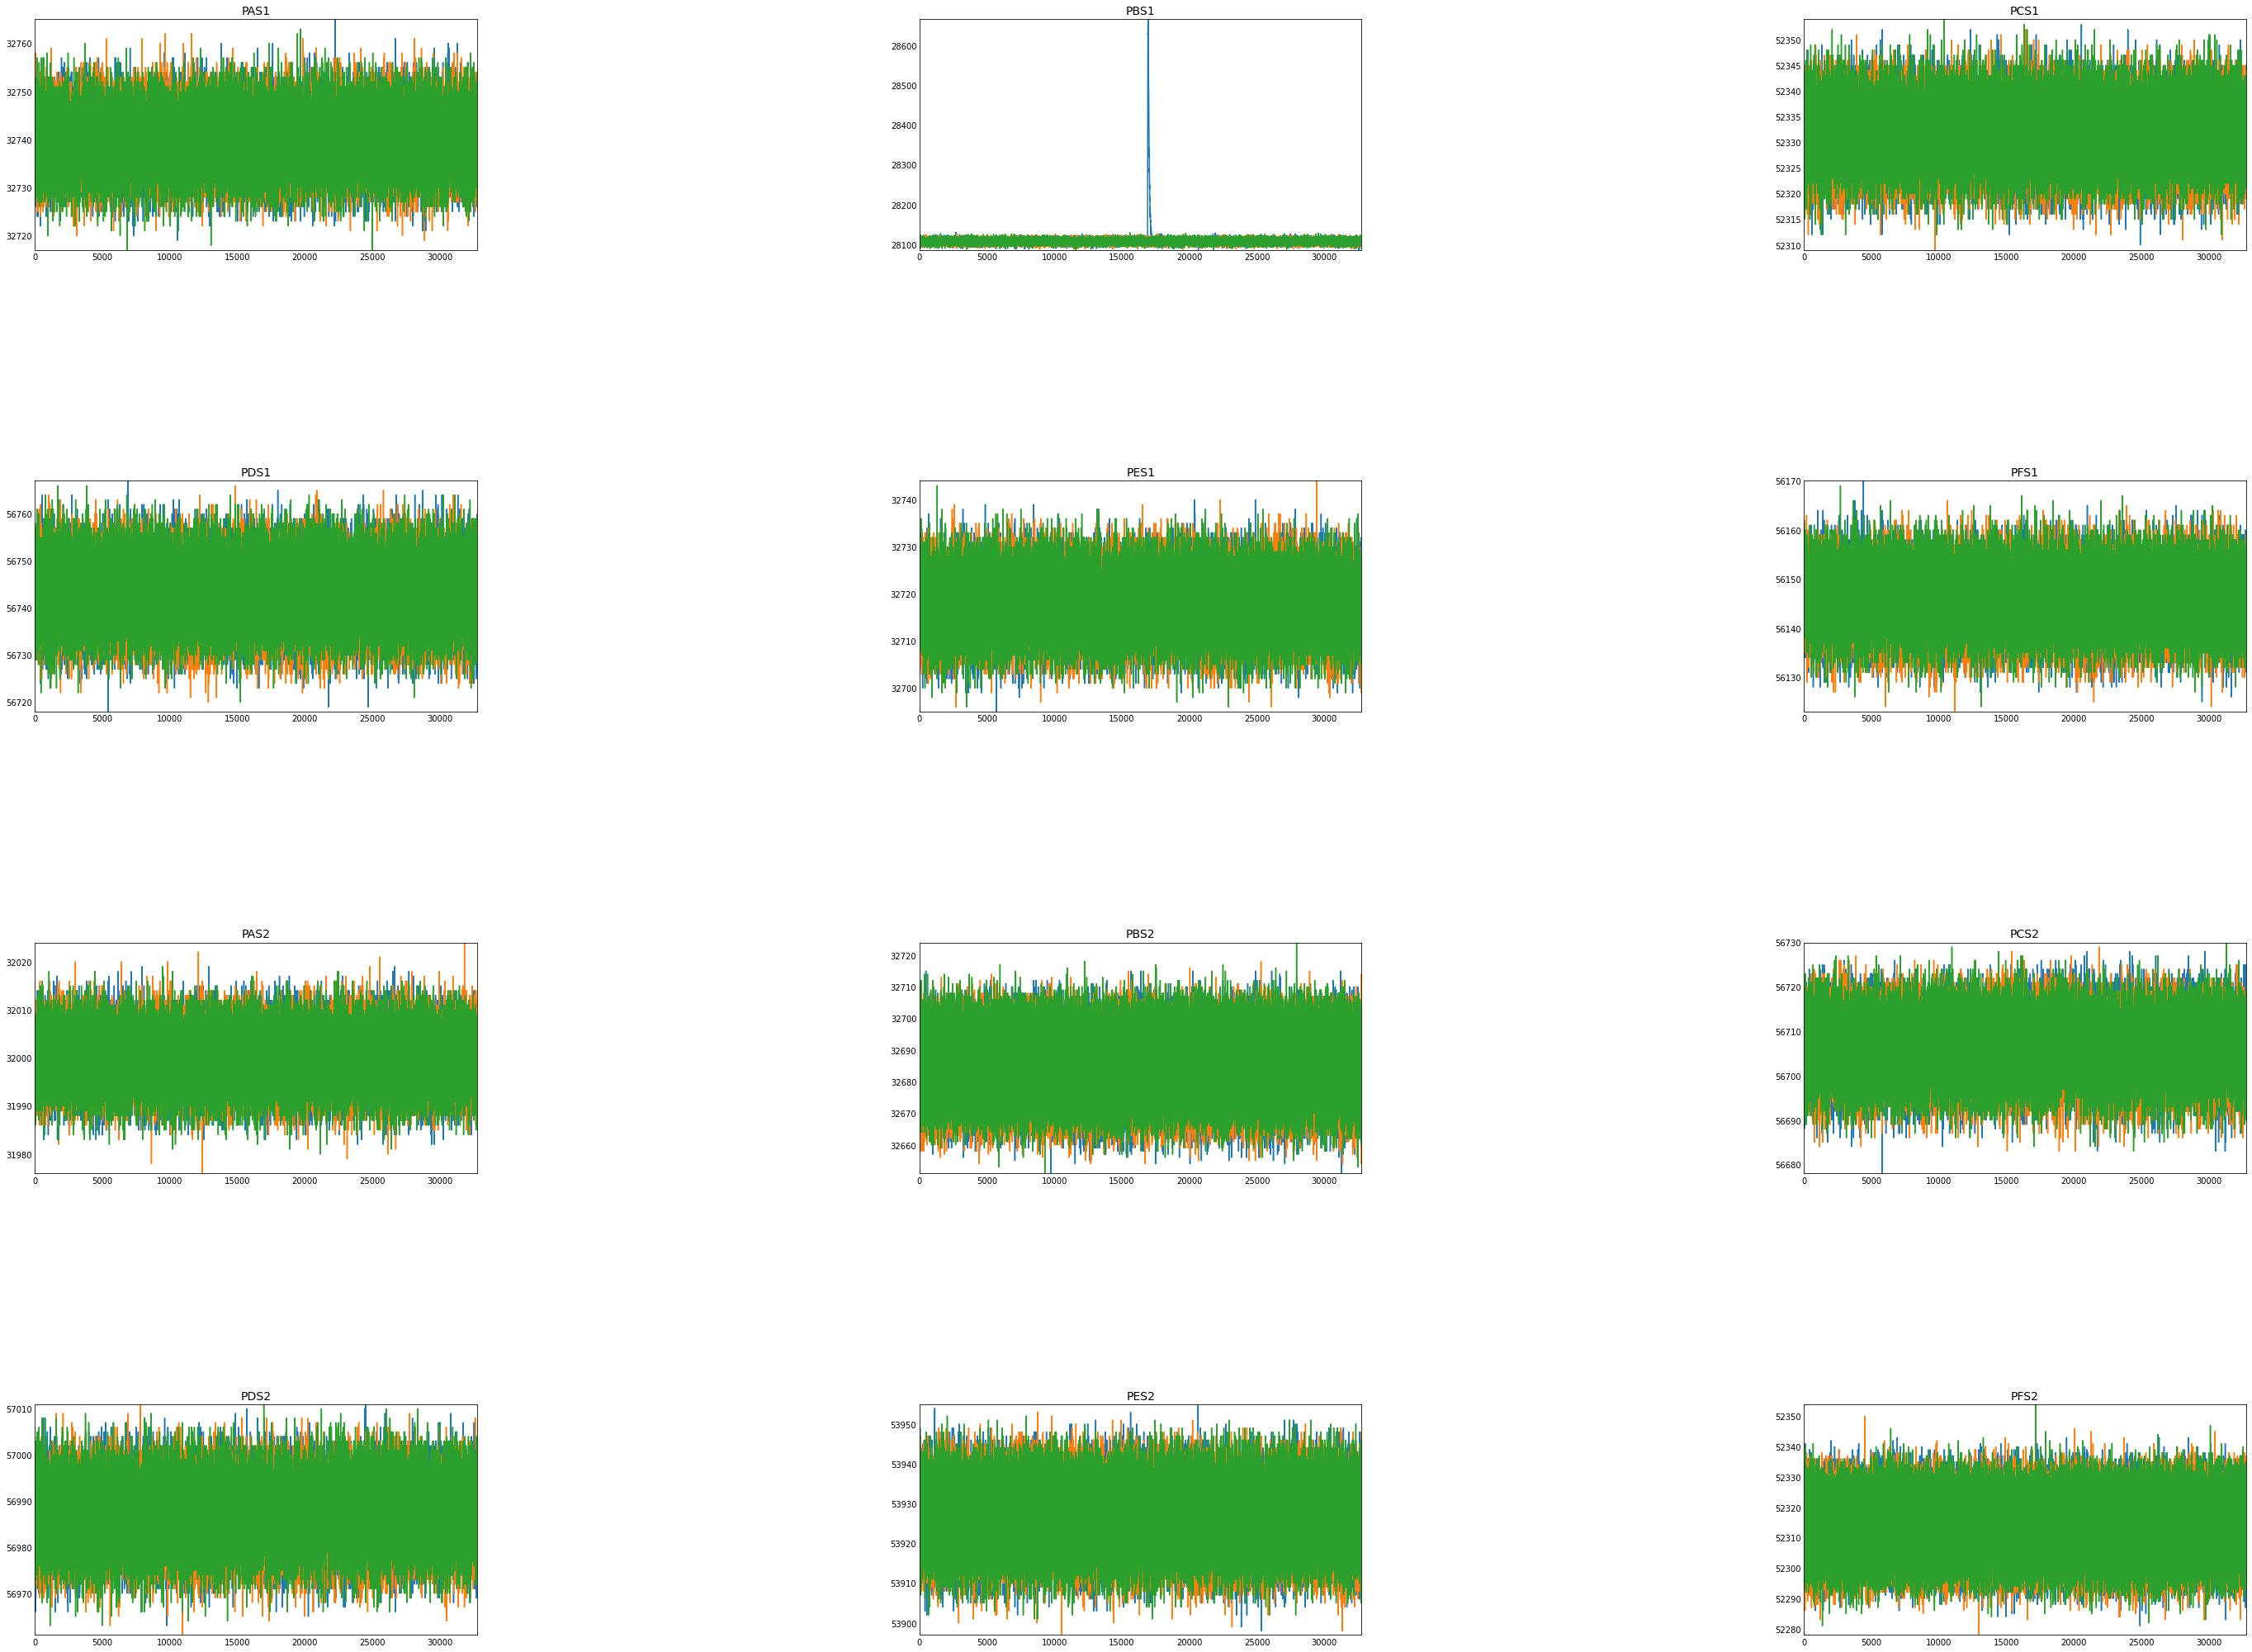

In [77]:
eventNumbers = [990001, 990002, 990003]

plt.figure(figsize=(48, 36))
for i in range(0, 12):
    #if chan_names[i] == 'PAS2':  # Replace YOUR_CHANNEL_NAME with the name of the channel you want to plot
    ax = plt.subplot(4, 3, i+1)
    for eventNumber in eventNumbers[:]:
        ax.plot(traces['Z5'][chan_names[i]][seriesNumber][eventNumber][:])
    ax.set_title(chan_names[i], fontsize=14)
    ax.set_xlabel('')
    ax.set_ylabel('')
    ax.tick_params(axis='both', which='both', length=0)
    ax.margins(0)
plt.subplots_adjust(wspace=1, hspace=1)
plt.show()